In [1]:
import random
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from preprocessing import get_X_and_y_tensors
from nested_crossval import run_nested_cv_for_model
from utils import *
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from skorch import NeuralNetRegressor
from utils import *


In [2]:
%load_ext autoreload
%autoreload 2

## 1. Getting X an y tensors

In [3]:
X,y=get_X_and_y_tensors()

In [4]:
X

tensor([[ 214.0000, 1725.6000, 1394.0000,  ...,    3.7160,  489.4000,
         2223.3000],
        [ 236.0000, 1769.8000, 1405.4000,  ...,    3.4940,  538.7000,
         2201.8999],
        [ 241.8000, 1724.9000, 1461.7000,  ...,    4.0230,  512.1000,
         2159.8999],
        ...,
        [ 253.1000, 2050.0000, 1669.8000,  ...,    5.1760,  610.0000,
         2648.2000],
        [ 212.1000, 1813.9000, 1468.0000,  ...,    2.8290,  548.4000,
         2262.6001],
        [ 245.7000, 2038.8000, 1655.6000,  ...,    5.9600,  606.9000,
         2704.3000]])

In [5]:
y

tensor([86.1055, 86.1435, 86.4169, 85.9599, 81.6936, 87.5331, 86.8410, 88.2468,
        87.5399, 88.1924, 87.7862, 86.2464, 86.1611, 86.5115, 86.8366, 84.9951,
        86.3812, 88.5102, 85.0129, 85.9784, 88.9662, 84.7507, 87.1134, 87.2657,
        85.5097, 87.1627, 84.8371, 86.8986, 87.4809, 88.2095, 83.4647, 86.3373,
        86.5872, 87.8968, 88.5642, 87.4188, 87.9764, 84.6742, 73.8372, 85.9425,
        86.5554, 87.6478, 87.5996, 86.1728, 88.3539, 87.2642, 86.7197, 85.2699,
        87.7586, 87.8977, 88.1691, 88.4375, 87.1276, 87.5950, 87.9379, 86.5774,
        87.3628, 88.5818, 89.5304, 87.1476, 87.9669, 87.8043, 86.0451, 88.7219,
        88.3917, 89.0096, 85.0285, 87.2786, 87.5549, 87.4504, 88.3307, 89.0777,
        86.8685, 89.4476, 88.6088, 87.6669, 87.6940, 89.0107, 89.6245, 89.4860,
        88.9843, 88.4306, 88.6367, 90.2405, 86.5774, 87.4385, 88.9093, 88.7257,
        88.8421, 88.8315, 87.8210, 88.9991, 88.5073, 90.3756, 91.2113, 88.8250])

## 2. Cross-validation objects

In [6]:
n_outer_cv=30
n_inner_cv=5
outer_cv=KFold(n_splits=n_outer_cv,shuffle=True, random_state=42)

## 3. Applying  NN

- `X` will be all the features except the ["CRUDE PROTEIN"], which we will try to predict
- `y`will be the ["CRUDE PROTEIN"]
- `loss_function`: RMSE

## 4. Hyperparameter tunning with Nested Crossfold validation

We chose nested cross-validation instead of a random train-test split because it gives a fairer and more reliable way to check our model’s performance. It has two steps: one for finding the best model settings (hyperparameters) and another for testing how well the model works on new data. This is important because if we tune and test the model on the same data, the results might look better than they actually are. 
By keeping these steps separate, nested cross-validation helps avoid this problem and gives a more honest estimate of how our model will perform on new, unseen data.

- For the inner fold of the nested cross-validation, we applied Grid Search to take advantage of all its built-in features like systematic parameter tuning and parallel processing. To make this work with the SLIM library, we implemented a custom wrapper called SLIMWrapper, which follows the BaseEstimator interface. This allowed us to integrate the SLIM seamlessly into the grid search process, ensuring efficient and consistent hyperparameter tuning within the inner loop.

### Updating weights

In our grid search we shall focus on the following parameters. Our goal is to manage our weights so that we may have a model both capable or learning and generalizing when looking at new data.

learning rate - controls the size of the step

weight_decay - adds a penalty to the loss function, encouraging smaller weights for  better generalization from the model. The penalty is substracted from the gradient during backpropagation with the objective of preventing excessive weight growth. Bigger penalties result in stronger regularization, rendering the event of overfitting less probable.


In [7]:
param_grid = {
    'optimizer__lr' : [1e-4, 1e-3, 1e-2],
    'optimizer__weight_decay': [1e-4, 1e-3, 0.01, 0.05]
}

#### Weights initialization
The output of a neuron in a linear layer is a weighted sum of inputs from the previous layer. Keeping both the input data and layer weights small ensures stable outputs, preventing extreme values that could slow training. 

To prevent unstable gradients, the initialization should ensure that the variance of the layer's inputs is close to that of its outputs and the variance of the gradients is the same before and after passing through the layer. The way to achieve this is different for each activation function. We shall use Xavier initialization since it is good for avoiding vanishing and exploding gradients.

Vanishing gradients
Neural networks often suffer from gradient instability during training. Sometimes, the gradients get smaller during the backward pass. This is known as vanishing gradients. As a result, earlier layers receive hardly any parameter updates and the model doesn't learn.

Exploding gradients
In other cases, the gradients get increasingly large, leading to huge parameter updates and divergent training. This is known as exploding gradients.

For Linear and Hidden layers, RELU is a great option given that it doesn't have a upper bound (f(x) = (max,0)). For positive inputs, the output equals the input and for negative equals zero. Nevertheless, the fact that negative cases equal zero results in null gradients (the model stops learning). Another varient is Leaky RELU, that is positive cases behaves like RELU and in negative case, inputs are a scaled by a small coefficient (Pytorch default is 0.01) which means that gradients never reach zero and the model never stops learning.

Dropout is a regularization technique that randomly deactivates a fraction of neurons during the process of training. The objective of this action is to prevent the model from becoming to dependent on some of the features. Dropout layers are set with a probability of neuron being deactivated (p argument). During training, it randomly deactivates neurons, while during evaluation it should be disabled for more stable predictions.

In [8]:
class Neural_Network(nn.Module):
    def __init__(self):
        super(Neural_Network, self).__init__()
        self.fc1 = nn.Linear(13, 8)
        self.drop1 = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(8, 5)
        self.drop2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(5, 3)
        self.drop3 = nn.Dropout(p=0.1)
        self.fc4 = nn.Linear(3, 1)
        self.apply(self.init_weights)

    def init_weights(self, atribute):
        if isinstance(atribute, nn.Linear):
            init.xavier_uniform_(atribute.weight)
            init.zeros_(atribute.bias)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = F.relu(self.fc3(x))
        x = self.drop3(x)
        x = self.fc4(x)
        return x.squeeze(-1)

    def predict(self, x):
        # Convert input to tensor to run through the model
        x_tensor = torch.tensor(x, dtype=torch.float32)
        output = self._module(x_tensor)
        # Convert output tensor to numpy array and flatten to fit the expected output shape
        return output.detach().numpy().ravel()

# Override the NeuralNetRegressor's fit method to accommodate our run_nested_cv_for_model function
class Fit_Regressor(NeuralNetRegressor):
    def __init__(self, *args, log_path="./logs", seed=84, X_test=None, y_test=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.log_path = log_path
        self.X_test = X_test
        self.y_test = y_test
        self.set_seed(seed)

    def set_seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)

    # Override Skorch's NeuralNetRegressor to log test loss after each epoch
    def on_epoch_end(self, model, **kwargs):
        super().on_epoch_end(model, **kwargs)

        if self.X_test is not None and self.y_test is not None:
            y_pred = self.predict(self.X_test)
            test_loss = self.criterion_(
                torch.tensor(y_pred), torch.tensor(self.y_test)
            ).item()
            self.history[-1]['test_loss'] = test_loss

    def fit(self, X_train, y_train, X_test=None, y_test=None, **kwargs):
        # Save test set for per-epoch use
        self.X_test = X_test
        self.y_test = y_test

        super().fit(X_train, y_train, **kwargs)

        # After training, update log file
        if hasattr(self, "log_path"):
            # Combine logs
            df = pd.DataFrame(self.history)
            df.to_csv(self.log_path, index=False)

        return self

# Get RMSE to use as loss function inside Skorch   
class RMSELoss(nn.Module):
    def forward(self, y_pred, y_true):
        return torch.sqrt(F.mse_loss(y_pred, y_true))


In [9]:
model = Neural_Network()

This model has 179 learnable parameters:
- Layer 1: (13 features + 1 bias) *  8 output neurons = 112 parameters
- Layer 2: (8 input neurons + 1 bias) * 5 output neurons = 45 parameters
- Layer 3: (5 input neurons + 1 bias) * 3 output neurons = 18 parameters
- Layer 4: (3 input neurons + 1 bias) * 1 output neuron = 4 parameters

In [10]:
total = 0
for parameter in model.parameters():
    total += parameter.numel()
print(total)

179


In [11]:
sc = StandardScaler()

In [12]:
# Cast to float32 to later override the scaler
float32 = FunctionTransformer(lambda X: X.astype('float32'), validate=False)

### Optimizer

Adaptive Moment Estimation (Adam)
Finally, Adaptive Moment Estimation or Adam is arguably the most versatile and widely used optimizer. It combines RMSprop with the concept of momentum: the average of past gradients where the most recent gradients have more weight. Basing the update on both gradient size and momentum helps accelerate training. Adam is often the default go-to optimizer.

Given our small dataset, we do not antecipate great computational cots so we decided to use ADAM as our default optimizer.

In [13]:
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X), start=1):
    nn_wrapper = Fit_Regressor(
        module=Neural_Network,
        max_epochs=20,
        train_split=None,
        optimizer= optim.Adam,
        criterion=RMSELoss,
        log_path= f"./results/NN/logs_best_params_fold_{i}",
        verbose=0,
        device='cpu',
    )

In [14]:
pipeline = make_pipeline(
    sc,
    float32,
    nn_wrapper
)

In [15]:
summary, general_summary, all_grid_results=run_nested_cv_for_model(X,y, nn_wrapper, param_grid, outer_cv, n_inner_cv, model_name="NN")


 Outer fold 1

Grid search completed!
Best parameters: {'optimizer__lr': 0.01, 'optimizer__weight_decay': 0.0001}
Best score: -87.01028289794922
Training with the best hyparameters of 1 fold
  epoch    test_loss    train_loss     dur
-------  -----------  ------------  ------
      1     293.0186      388.2364  0.0020
      2     234.0538      319.6167  0.0030
      3     184.7381      256.4999  0.0022
      4     144.7646      189.4822  0.0042
      5     113.4953      160.6277  0.0025
      6      90.6986      118.3225  0.0040
      7      89.5913      110.6029  0.0040
      8      89.5797      101.3953  0.0020
      9      89.5680       97.3895  0.0040
     10      89.5561       90.5576  0.0043
     11      89.5442       93.0026  0.0031
     12      89.5322       95.6046  0.0033
     13      89.5201       88.3438  0.0040
     14      89.5079       88.1071  0.0045
     15      89.4956       88.0655  0.0041
     16      89.4833       86.8868  0.0040
     17      89.4710       87.6019

In [16]:
plot_NN_loss_logs("NN", n_outer_cv, 'sustavianfeed')

Looking across folds, we notice that the model is robust as performance follows a single trend. The model show learning ability, proved by the considerable decrease in RMSE over the first 5 epochs. Nevertheless, the model quickly stagnates in performance never showing any significant drop after the 6th epoch for the test data (training data stagnates around epoch 13)

In [17]:
plot_NN_average_loss("NN", n_outer_cv, 'sustavianfeed')

The single trend mentioned above clearly show asthe same conclusions will be taken after looking at the average results. The training data take a little more time to stagnate but overall both end with identical results.

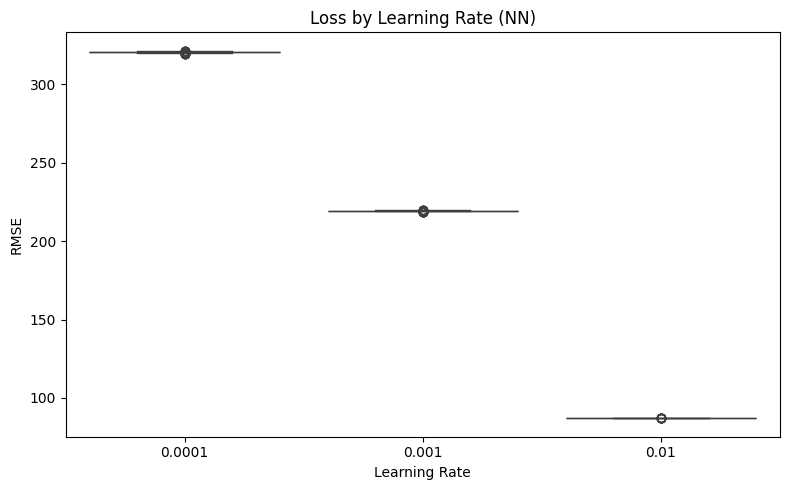

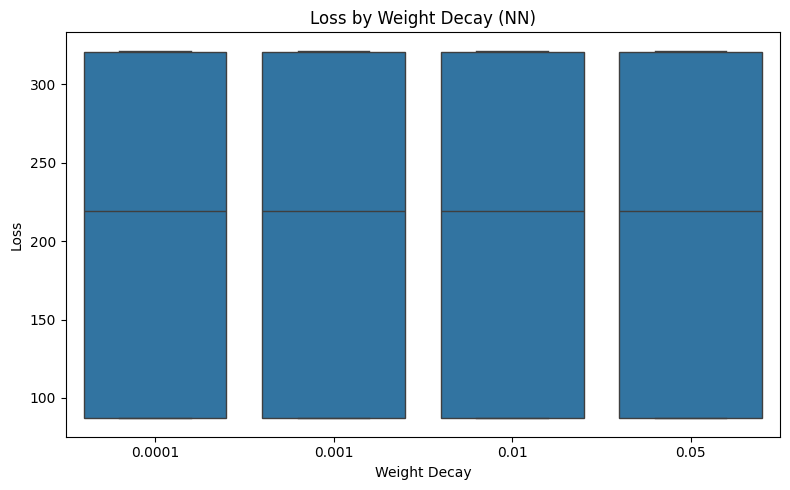

In [18]:
plot_param_boxplots("results/NN/all_folds_grid_search_results.csv", model_name="NN")

In general, we notice that for our weight decay values there wasn't any difference. All three have about the same median, upper and lower bounds so we may refer that the specific value of the weight decay didn't have much importance in the performance. When it comes to learning rate, we visually can assume that 0.01 was the better value of the three as its upper bound is vastly lower than the other two's lower bounds. A statistcal test seems to not be needed but we shall make one to reinforce our conclusion.

In [19]:
stat_test_lr_('./results/NN/all_folds_grid_search_results.csv')

Kruskal-Wallis H-test between learning rates:
Statistic = 319.1196, p-value = 5.059e-70
→ Significant difference between learning rates (p < 0.05)


As we expected, there is enough evidence for us to determine that the difference between learning rates is statiscally significant.

Given our conclusions above, we will check now the performance with basis on the combination of both hyperparameters.

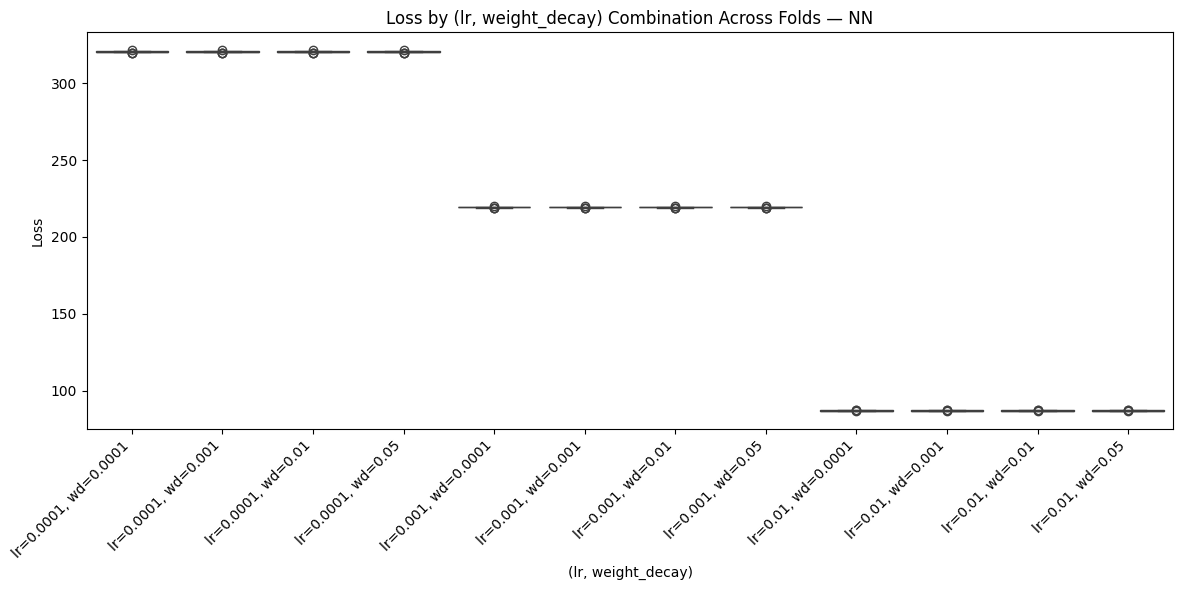

In [20]:
plot_rmse_by_lr_weight_decay_combo("results/NN/all_folds_grid_search_results.csv", model_name="NN")

The results further bolster our conjecture since the differences go along the verified differences in learning rate. Once again we will procede with a statistical test to substatntiate our conclusions.

In [21]:
stat_test_param_combinations("results/NN/all_folds_grid_search_results.csv")

Kruskal-Wallis H-test across (lr, weight_decay) combinations:
Statistic = 319.1460, p-value = 8.038e-62
→ Statistically significant difference between combinations.


### Conclusions

Our model shows an early ability to learn with training and test data moving downwards in a similar trend. But early on, specially for test data, early convergence becomes the noticeable trend. We may conclude that the model started overfitting since training continued improving albeit slowly while test had long stopped getting better results but once again the main problem is the plateauing of the performance. We believe that the main reason for the problems refered in the lack of data as our dataset is very little.
For further studies, we may propose to ourselves to expand our parameter grid and experiment with other models with different size but as stated having access to more data would be, in our view, the best solution for model improvement. If not posible, than data augmentantion methods may be considered.